In [ ]:
%store -r

import pandas as pd

df1 = df.drop(columns=["ap_hi", "ap_lo", "height", "weight", "BMI"])
df2 = df.drop(columns=["Obesity", "HBP", "height", "weight"])

df1 = pd.get_dummies(df1, columns=["Obesity", "HBP", "gender"])
df2 = pd.get_dummies(df2, columns=["gender"])

In [4]:
from sklearn.model_selection import train_test_split

X1, y1 = df1.drop("cardio", axis=1), df1["cardio"]
X2, y2 = df2.drop("cardio", axis=1), df2["cardio"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, random_state=42)

X1_val, X1_test, y1_val, y1_test = train_test_split(X1_test, y1_test, test_size=0.5, random_state=42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_test, y2_test, test_size=0.5, random_state=42)

print(X1_train.shape, X1_val.shape, X1_test.shape, y1_train.shape, y1_val.shape, y1_test.shape)
print(X2_train.shape, X2_val.shape, X2_test.shape, y2_train.shape, y2_val.shape, y2_test.shape)

(40162, 19) (13388, 19) (13388, 19) (40162,) (13388,) (13388,)
(40162, 12) (13388, 12) (13388, 12) (40162,) (13388,) (13388,)


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
sX1_train = scaler.fit_transform(X1_train)
sX1_val = scaler.transform(X1_val)
sX1_test = scaler.transform(X1_test)

sX2_train = scaler.fit_transform(X2_train)
sX2_val = scaler.transform(X2_val)
sX2_test = scaler.transform(X2_test)

scaler = MinMaxScaler()
scaler.fit(sX1_train)
snX1_train=scaler.transform(sX1_train)
snX1_test=scaler.transform(sX1_test)
snX1_val=scaler.transform(sX1_val)

scaler.fit(sX2_train)
snX2_train=scaler.transform(sX2_train)
snX2_test=scaler.transform(sX2_test)
snX2_val=scaler.transform(sX2_val)

              precision    recall  f1-score   support

           0       0.67      0.79      0.72      6874
           1       0.73      0.60      0.65      6514

    accuracy                           0.69     13388
   macro avg       0.70      0.69      0.69     13388
weighted avg       0.70      0.69      0.69     13388



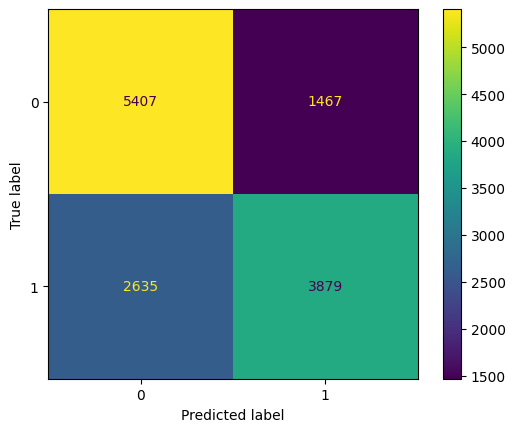

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

def KNN(xtr,ytr,min,max):
    pipe_KNN=Pipeline([("scaler", scaler), ("knn", KNeighborsClassifier())])
    param_grid_KNN = {"knn__n_neighbors": list(range(min,max))}
    classifier_KNN = GridSearchCV(estimator=pipe_KNN, param_grid=param_grid_KNN, scoring="accuracy")
    classifier_KNN.fit(xtr, ytr)
    classifier_KNN.best_estimator_.get_params()
    return classifier_KNN

def CMD(clf,xval,yval):
    y_pred=clf.predict(xval)
    print(classification_report(yval, y_pred))
    cm=confusion_matrix(yval, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    
a=KNN(snX1_train,y1_train,1,30)
CMD(a, snX1_val, y1_val)


In [11]:
a

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 6, 7, 8, 9]},
             scoring='accuracy')

In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

clf1=LogisticRegression(l1_ratio=0.9, penalty="elasticnet", solver="saga")
clf2=KNeighborsClassifier(n_neighbors=25)
clf3=SVC(gamma=1, C=1, kernel="rbf")

eclf1=VotingClassifier(estimators=[("log",clf1), ("knn",clf2), ("svc",clf3)],voting="hard")
eclf1.fit(snX1_train, y1_train)

y1_pred = eclf1.predict(snX1_val)
y1_pred


array([0, 0, 1, ..., 0, 1, 0], shape=(13388,))

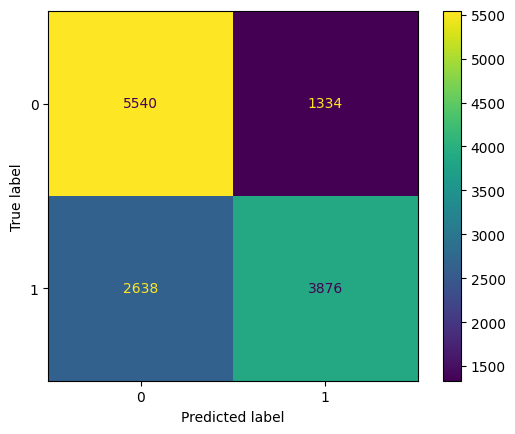

In [18]:
cm=confusion_matrix(y1_val, y1_pred)
ConfusionMatrixDisplay(cm).plot()